# Analítica de datos - ejemplo de clase - comparación distintos métodos de regresión

## Lectura base de datos y partición conjunto de entrenamiento y conjunto de evaluación

Nota: conjunto de evaluación no se utiliza en NINGUNA etapa de entrenamiento 

In [1]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from funciones_fifa import dummy_fifa, pre_exploratorio, save_fig, code_euro

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = 'datos/data.csv'

Xdata = pd.read_csv(csv_path)

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From']
Xdata.drop(columns = col_drop, inplace = True)


In [2]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest = train_test_split(Xdata,test_size=0.975) #fijar en 0.3 para entrenar -- 0.95 para demostrar funcionalidad del código
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)

ytrain = SimpleImputer(strategy="most_frequent").fit_transform(pd.DataFrame(ytrain)).reshape(-1)
ytrain = code_euro(ytrain)

ytest = SimpleImputer(strategy="most_frequent").fit_transform(pd.DataFrame(ytest)).reshape(-1)
ytest = code_euro(ytest)


In [4]:
col_euro = ['Value','Wage'];
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB'];

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']
items = [] 
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))

dummy = dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = dummy.fit_transform(Xtrain)


In [5]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 4199 to 4966
Data columns (total 81 columns):
Age                         455 non-null int64
Nationality                 455 non-null float64
Overall                     455 non-null int64
Potential                   455 non-null int64
Club                        455 non-null float64
Value                       455 non-null float64
Wage                        455 non-null float64
Special                     455 non-null int64
Preferred Foot              455 non-null float64
International Reputation    455 non-null float64
Weak Foot                   455 non-null float64
Skill Moves                 455 non-null float64
Work Rate                   455 non-null float64
Body Type                   455 non-null float64
Real Face                   455 non-null float64
Position                    455 non-null float64
Jersey Number               455 non-null float64
Joined                      455 non-null float64
Contract Valid Un

[t-SNE] Computing 34 nearest neighbors...
[t-SNE] Indexed 455 samples in 0.002s...
[t-SNE] Computed neighbors for 455 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 455 / 455
[t-SNE] Mean sigma: 2.453162
[t-SNE] Computed conditional probabilities in 0.016s
[t-SNE] Iteration 50: error = 74.6969986, gradient norm = 0.4693960 (50 iterations in 0.235s)
[t-SNE] Iteration 100: error = 71.0257874, gradient norm = 0.4743086 (50 iterations in 0.220s)
[t-SNE] Iteration 150: error = 70.6059875, gradient norm = 0.5019143 (50 iterations in 0.189s)
[t-SNE] Iteration 200: error = 70.0177612, gradient norm = 0.4840829 (50 iterations in 0.225s)
[t-SNE] Iteration 250: error = 70.0769730, gradient norm = 0.4865320 (50 iterations in 0.297s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.076973
[t-SNE] KL divergence after 251 iterations: 17976931348623157081452742373170435679807056752584499659891747680315726078002853876058955863276687817154045895351438246

Guardando... relevancia_PCA


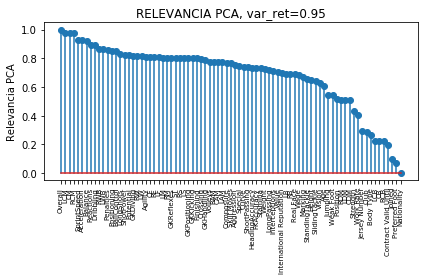

Guardando... tsne_2D


True

In [6]:
#%% Paso 3 : Analisis exploratorio
#preproceso entrada  y salida para analisis exploratorio
img_path = 'im2/'
pre_exploratorio(Xtrain_pre,ytrain,img_path,col_sal)

In [7]:
#%% Paso 4 : Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.externals import joblib #https://joblib.readthedocs.io/en/latest/

steps=[[('dummy_pre', dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
        ('rep',  PCA()),
        ('reg', RandomForestRegressor())],
       [('dummy_pre', dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
        ('reg', KernelRidge())],
       [('dummy_pre', dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
        ('reg', ElasticNet())],
       [('dummy_pre', dummy_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
        ('reg', BayesianRidge())],
      ]
parameters = [{
              'rep__n_components' : [0.8,0.9],              
              'reg__max_depth': [8],
              'reg__n_estimators' : [10],
              },
              {          
               'reg__kernel': ['poly'],
               'reg__degree' : [1,2,3],
               },
              {
               'reg__alpha': [0.01,0.1,1,10],
               'reg__l1_ratio' : [0.01,0.5,0.9],
               },
                {
               #'reg__alpha_1': [1e-6,1e-5,1e-3],
               'reg__alpha_2': [1e-6,1e-5,1e-3],
               #'reg__lambda_1': [1e-6,1e-5,1e-3],
               'reg__lambda_2': [1e-6,1e-5,1e-3],
               }
             ]

label_models = ['PRE_PCA_RanForest','PRE_RidgeReg_poly',
                'PRE_Elastic_Net','PRE_BayesianRidge']

best_model = []
filename = 'resultados/fifa_comp'
for i in range(len(steps)):
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='neg_mean_absolute_error',verbose=10)
    grid_search.fit(Xtrain, ytrain)
    #print(grid_search.cv_results_)
    #mejor modelo entrenado
    best_model += [grid_search.best_estimator_]
    joblib.dump(best_model,filename+".pkl")

print('Mejores modelos:\n')
best_model

modelo 1/4
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   12.9s remaining:   30.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   13.6s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   13.6s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.1s finished


modelo 2/4
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    7.9s remaining:   51.6s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    8.0s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    8.0s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    8.2s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   15.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   15.7s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.9s finished


modelo 3/4
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed:   56.3s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.0min finished


modelo 4/4
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed:   47.1s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   48.4s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   54.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   54.4s finished


Mejores modelos:



[Pipeline(memory=None,
      steps=[('dummy_pre', dummy_fifa(cat_usr={'Nationality': ['England', 'Germany', 'Spain', 'Argentina', 'France', 'Brazil', 'Italy', 'Colombia', 'Japan', 'Netherlands', 'Sweden', 'China PR', 'Chile', 'Republic of Ireland', 'Mexico', 'United States', 'Poland', 'Norway', 'Saudi Arabia', 'Denmark', 'Korea...ators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False))]),
 Pipeline(memory=None,
      steps=[('dummy_pre', dummy_fifa(cat_usr={'Nationality': ['England', 'Germany', 'Spain', 'Argentina', 'France', 'Brazil', 'Italy', 'Colombia', 'Japan', 'Netherlands', 'Sweden', 'China PR', 'Chile', 'Republic of Ireland', 'Mexico', 'United States', 'Poland', 'Norway', 'Saudi Arabia', 'Denmark', 'Korea...reg', KernelRidge(alpha=1, coef0=1, degree=1, gamma=None, kernel='poly',
       kernel_params=None))]),
 Pipeline(memory=None,
      steps=[('dummy_pre', dummy_fifa(cat_usr={'Nationality': ['England', 'Germany', 'Spain', 'Argentina'

# Calcular rendimiento en cojunto de test

In [8]:
#%% Paso 5: evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
ytest_e = np.zeros((Xtest.shape[0],len(my_model_loaded)))
vmae = np.zeros((Xtest.shape[0],len(my_model_loaded)))
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %d/%d' % (i+1,len(my_model_loaded)))
    ytest_e[:,i] = my_model_loaded[i].predict(Xtest)
    vmae[:,i] = mean_absolute_error(np.array(ytest).reshape(1,-1),np.array(ytest_e[:,i]).reshape(1,-1),multioutput='raw_values')
    print('Hecho\n')


Evaluando modelo 1/4
Hecho

Evaluando modelo 2/4
Hecho

Evaluando modelo 3/4
Hecho

Evaluando modelo 4/4
Hecho



resultados/fifa_comp
Guardando... mae_testing_set


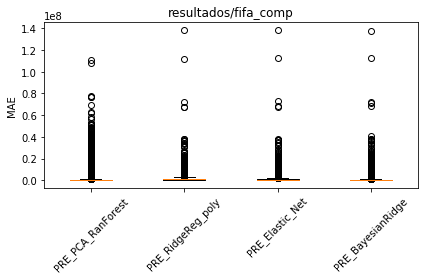

Desempeño promedio


array([1171674.47539109, 1207661.87573231, 1029795.32483343,
        909678.74993617])

In [9]:
#graficar boxplot
plt.boxplot(vmae)
print(filename)
plt.xticks(range(1,len(my_model_loaded)+1),labels=label_models,rotation=45)
plt.ylabel('MAE')
#plt.ylim([-0.01e8,0.1e8])
plt.title(filename)
save_fig(img_path,"mae_testing_set")
plt.show()
print('Desempeño promedio')
vmae.mean(axis=0)


In [10]:
my_model_loaded[2].get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('dummy_pre', dummy_fifa(cat_usr={'Nationality': ['England', 'Germany', 'Spain', 'Argentina', 'France', 'Brazil', 'Italy', 'Colombia', 'Japan', 'Netherlands', 'Sweden', 'China PR', 'Chile', 'Republic of Ireland', 'Mexico', 'United States', 'Poland', 'Norway', 'Saudi Arabia', 'Denmark', 'Korea...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])>